<a href="https://colab.research.google.com/github/cloudyafilia/Klasifikasi-Gambar-Dicoding/blob/main/MONEY_TALKS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Impor Library

In [1]:
!pip install gdown

In [2]:
!pip install -q gTTS

In [40]:
!pip install tensorflowjs

In [3]:
import os
import zipfile
import shutil
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import gdown
import tensorflow as tf
import tensorflow.keras.backend as K
from pathlib import Path
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.layers import BatchNormalization
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report
from keras.saving import save_model
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.models import load_model
from gtts import gTTS
import IPython.display as ipd
from IPython.display import display, Javascript
from PIL import Image
import io
import time

# Loading Data

In [4]:
# ID file dari Google Drive (link terbaru)
file_id = '1b93cxdixIcUp8axQk9nYw0o6vblHKrUh'

# URL untuk mengakses file di Google Drive
url = f'https://drive.google.com/uc?export=download&id={file_id}'

# Menyusun path untuk file zip dan folder ekstraksi
zip_file_path = '/content/dataset.zip'
extracted_folder_path = '/content/rupiah_dataset/'

# Mendownload file
gdown.download(url, zip_file_path, quiet=False)

# Mengekstrak file zip ke folder tujuan
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder_path)

print("Dataset berhasil diekstrak!")

# Path dataset dan folder output untuk data split
varied_dataset_path = '/content/rupiah_dataset/Data_Rupiah_Baru'
output_split_path = '/content/data_split/'


Downloading...
From (original): https://drive.google.com/uc?export=download&id=1b93cxdixIcUp8axQk9nYw0o6vblHKrUh
From (redirected): https://drive.google.com/uc?export=download&id=1b93cxdixIcUp8axQk9nYw0o6vblHKrUh&confirm=t&uuid=a4de65ce-8f65-465c-9225-423af0d12b1f
To: /content/dataset.zip
100%|██████████| 4.89G/4.89G [00:48<00:00, 100MB/s]


Dataset berhasil diekstrak!


In [5]:
# Menyusun path untuk dataset yang sudah diunduh dan diekstrak
zip_file_path = '/content/dataset.zip'
extracted_folder_path = '/content/rupiah_dataset/'

# Ekstrak file zip
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder_path)

print("Dataset berhasil diekstrak!")

# Path dataset dan folder output split
varied_dataset_path = '/content/rupiah_dataset/Data_Rupiah_Baru'
output_split_path = '/content/data_split/'

Dataset berhasil diekstrak!


# Data Visualization

In [6]:
from PIL import Image

# Path ke folder dataset
directory = '/content/rupiah_dataset/Data_Rupiah_Baru'

# Fungsi untuk mencetak resolusi gambar
def print_images_resolution(directory):
    unique_sizes = set()
    total_images = 0

    # Loop semua subdirektori (kelas nominal uang)
    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)

        if os.path.isdir(subdir_path):
            image_files = [f for f in os.listdir(subdir_path) if f.lower().endswith(('jpg', 'jpeg', 'png'))]
            num_images = len(image_files)
            print(f"{subdir}: {num_images} images")
            total_images += num_images

            # Loop tiap gambar dan ambil resolusinya
            for img_file in image_files:
                img_path = os.path.join(subdir_path, img_file)
                try:
                    with Image.open(img_path) as img:
                        unique_sizes.add(img.size)
                except Exception as e:
                    print(f"Error opening image {img_path}: {e}")

    # Tampilkan hasil
    print("\nUnique image sizes:")
    for size in unique_sizes:
        print(f"- {size}")

    print("---------------")
    print(f"\nTotal images across all subdirectories: {total_images}")

# Panggil fungsi untuk mencetak resolusi gambar
print_images_resolution(directory)

20000: 3332 images
2000: 3257 images
1000: 3262 images
100000: 3358 images
10000: 3339 images
5000: 3358 images
50000: 3347 images

Unique image sizes:
- (960, 1280)
- (1600, 708)
- (720, 1280)
- (3024, 4032)
- (1600, 900)
- (1200, 1600)
- (931, 1600)
- (4160, 3120)
- (900, 1600)
- (1599, 899)
- (224, 224)
- (577, 433)
- (1280, 720)
- (3120, 4160)
- (1280, 960)
- (576, 1024)
- (899, 1599)
- (1600, 1200)
---------------

Total images across all subdirectories: 23253


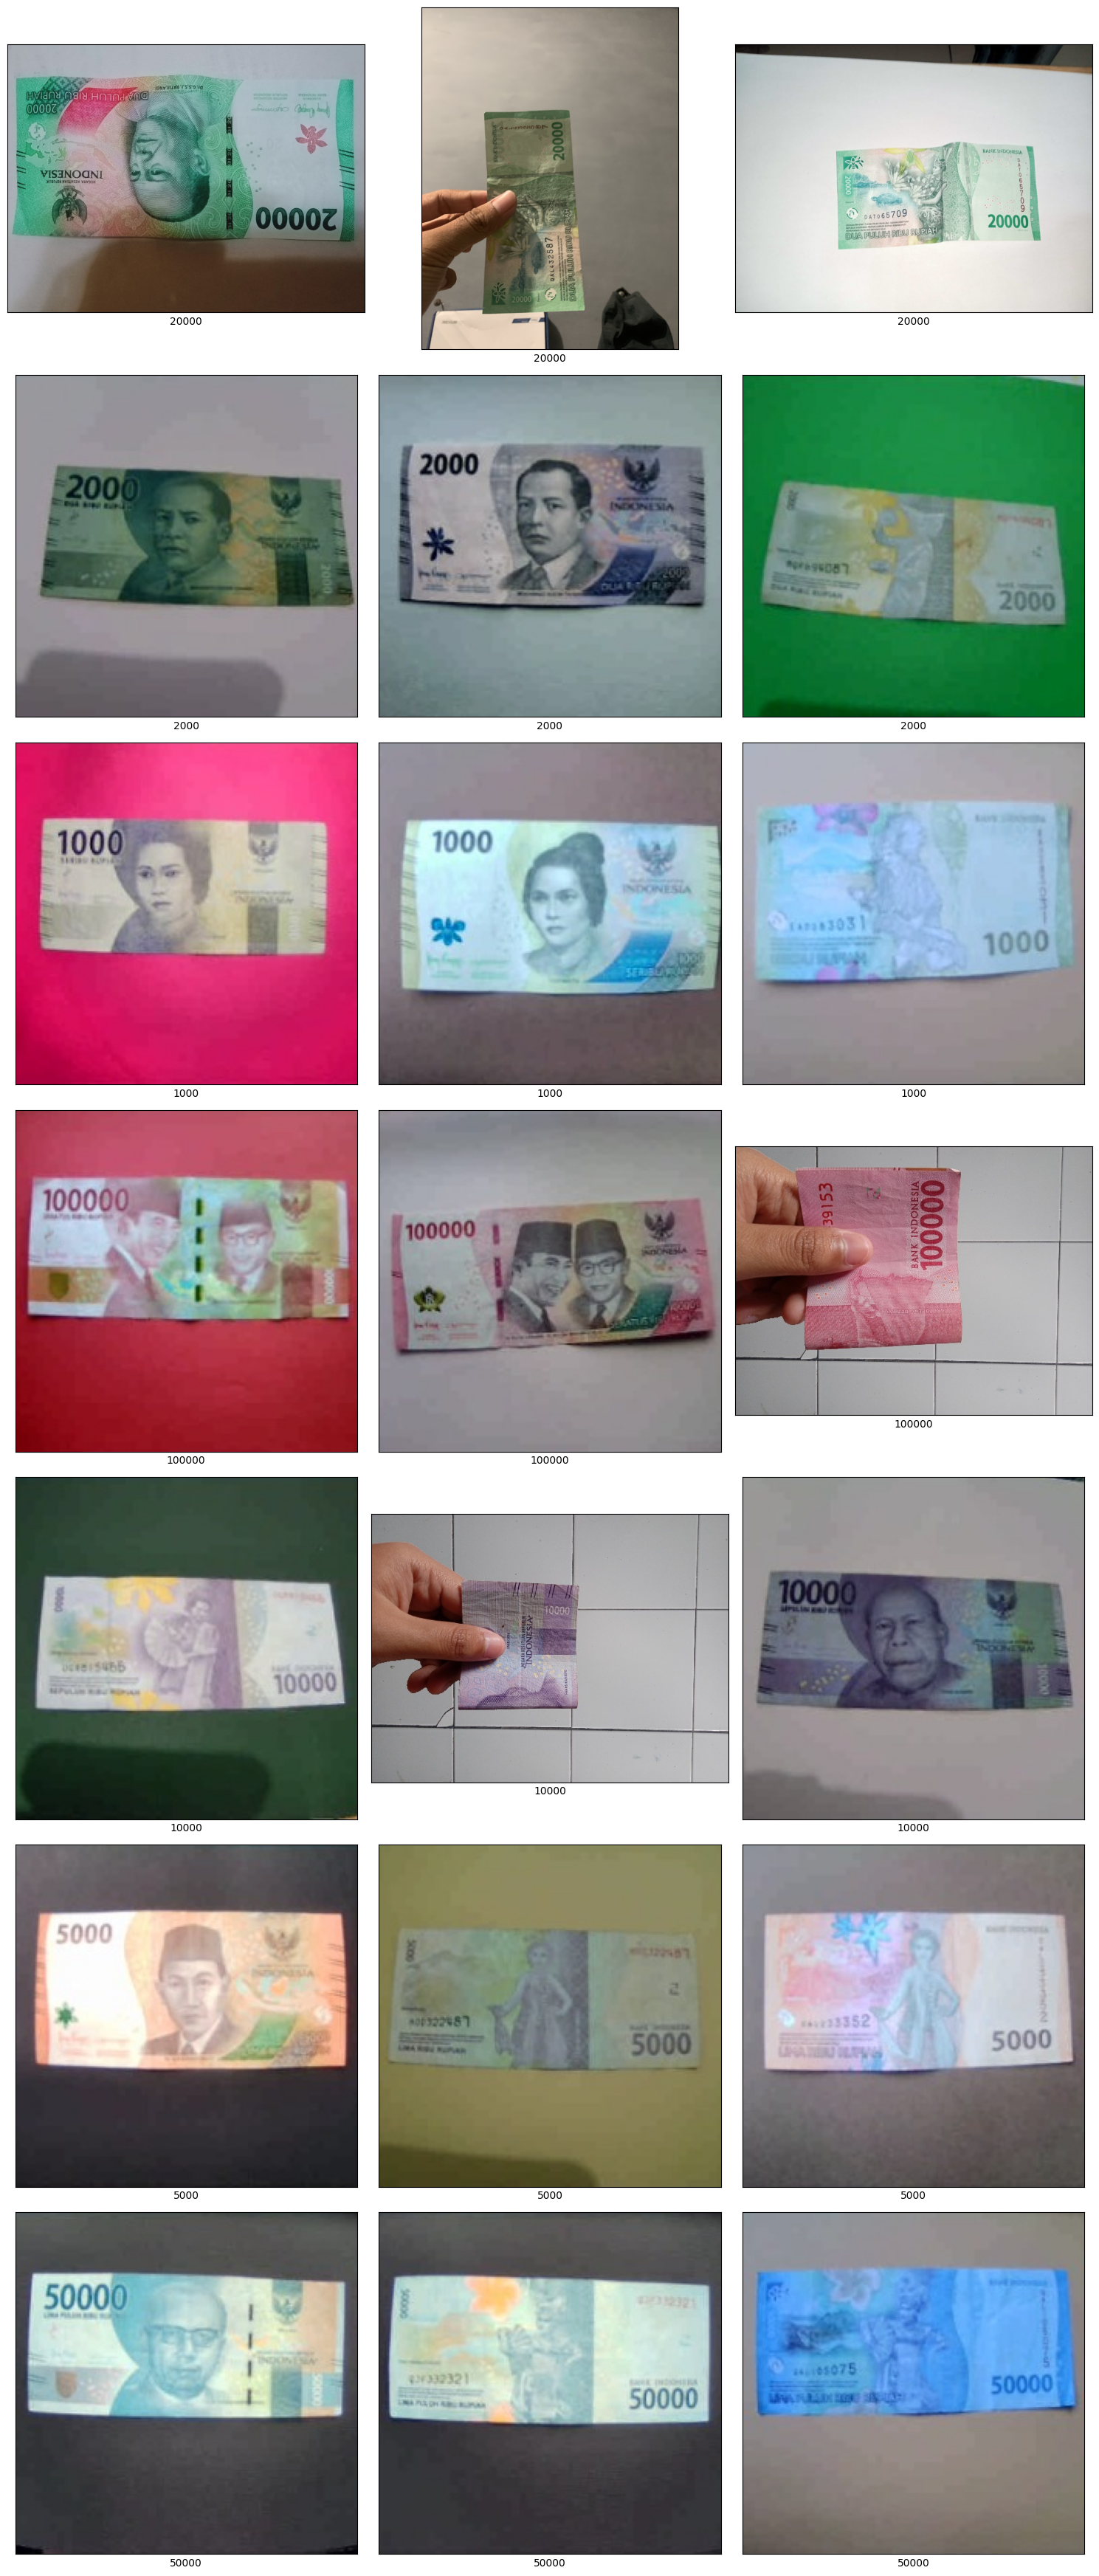

In [7]:
# Menyusun path ke folder dataset
path = "/content/rupiah_dataset/Data_Rupiah_Baru"

# Dictionary untuk menyimpan gambar berdasarkan kelas (nominal uang)
imgs = {}

# Load data ke dictionary per kelas (nominal uang)
for class_name in os.listdir(path):
    class_path = os.path.join(path, class_name)
    if os.path.isdir(class_path):
        imgs[class_name] = [f for f in os.listdir(class_path) if f.lower().endswith(('jpg', 'jpeg', 'png'))]

# Visualisasi: ambil 3 gambar acak per kelas
fig, axs = plt.subplots(len(imgs.keys()), 3, figsize=(15, 5 * len(imgs)))

# Jika hanya 1 kelas, axs tidak berbentuk array 2D
if len(imgs) == 1:
    axs = np.expand_dims(axs, axis=0)

for i, class_name in enumerate(imgs.keys()):
    images = np.random.choice(imgs[class_name], 3, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path, class_name, image_name)
        try:
            img = Image.open(img_path).convert("RGB")
            axs[i, j].imshow(img)
            axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])
        except Exception as e:
            print(f"Error displaying image {img_path}: {e}")
            axs[i, j].axis('off')
            axs[i, j].set(xlabel=f"{class_name} (error)")

fig.tight_layout()
plt.show()

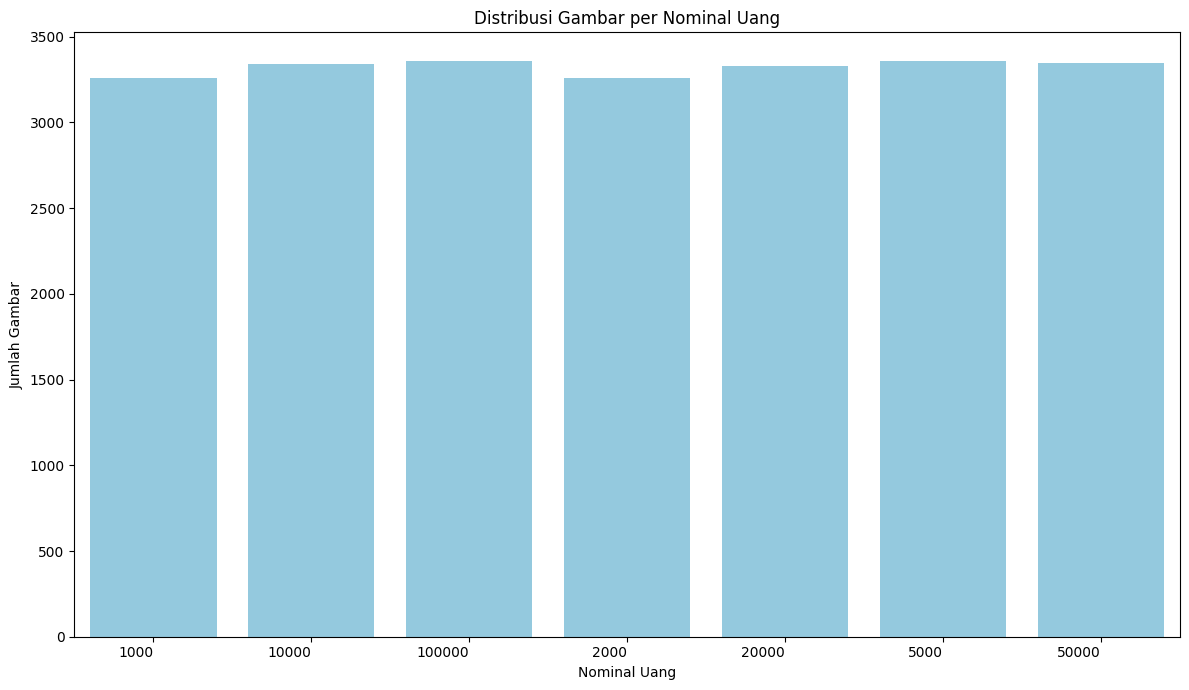

In [8]:
# Tentukan path dataset
mypath = '/content/rupiah_dataset/Data_Rupiah_Baru'
file_name = []
labels = []
full_path = []

# Telusuri semua file gambar beserta labelnya (nama folder = label)
for path, subdirs, files in os.walk(mypath):
    for name in files:
        if name.lower().endswith(('.jpg', '.jpeg', '.png')):
            full_path.append(os.path.join(path, name))
            labels.append(os.path.basename(path))
            file_name.append(name)

# Buat DataFrame
df = pd.DataFrame({"path": full_path, 'file_name': file_name, "labels": labels})

# Hitung jumlah gambar per label
label_counts = df.groupby('labels').size().reset_index(name='count')

# Visualisasi distribusi gambar per label
plt.figure(figsize=(12, 7))
ax = sns.barplot(x='labels', y='count', data=label_counts, color='skyblue')

# Format tampilan
plt.xticks(ha='right')
plt.xlabel("Nominal Uang")
plt.ylabel("Jumlah Gambar")
plt.title('Distribusi Gambar per Nominal Uang')
plt.tight_layout()
plt.show()


# Splitting Data

In [9]:
def split_dataset(input_path, output_path, seed=42, train_size=0.8, val_size=0.1, test_size=0.1):
    random.seed(seed)

    if os.path.exists(output_path):
        shutil.rmtree(output_path)

    for split in ['train', 'val', 'test']:
        os.makedirs(os.path.join(output_path, split), exist_ok=True)

    def get_all_images(folder):
        image_files = []
        for ext in ['jpg', 'jpeg', 'png']:
            image_files += list(Path(folder).glob(f'**/*.{ext}'))
            image_files += list(Path(folder).glob(f'**/*.{ext.upper()}'))
        return [str(f) for f in image_files]

    # Memisahkan berdasarkan folder nominal
    labels = [f for f in os.listdir(input_path) if os.path.isdir(os.path.join(input_path, f))]

    split_counts = []

    for label in labels:
        label_path = os.path.join(input_path, label)
        images = get_all_images(label_path)

        if len(images) < 1:
            continue

        train_imgs, temp_imgs = train_test_split(images, test_size=(1-train_size), random_state=seed)
        val_imgs, test_imgs = train_test_split(temp_imgs, test_size=test_size/(test_size + val_size), random_state=seed)

        def copy_files(files, split):
            split_label_dir = os.path.join(output_path, split, label)
            os.makedirs(split_label_dir, exist_ok=True)
            for f in files:
                shutil.copy(f, split_label_dir)
            return len(files)

        split_counts.append({
            "Label": label,
            "Train": copy_files(train_imgs, 'train'),
            "Val": copy_files(val_imgs, 'val'),
            "Test": copy_files(test_imgs, 'test')
        })

    # Membuat dataframe untuk melihat hasil pembagian
    df_split = pd.DataFrame(split_counts)
    df_split.sort_values(by="Label", inplace=True)
    df_split.reset_index(drop=True, inplace=True)
    return df_split

# Jalankan fungsi untuk membagi dataset
df_result = split_dataset(varied_dataset_path, output_split_path)
print(df_result)


    Label  Train  Val  Test
0    1000   2609  326   327
1   10000   2671  334   334
2  100000   2686  336   336
3    2000   2605  326   326
4   20000   2665  333   334
5    5000   2686  336   336
6   50000   2677  335   335


# Modelling

Found 18599 files belonging to 7 classes.
Using 14880 files for training.
Found 18599 files belonging to 7 classes.
Using 3719 files for validation.


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 7, 7, 1280)     │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,592,839 (9.89 MB)

 Trainable params: 2,193,735 (8.37 MB)

 Non-trainable params: 399,104 (1.52 MB)

Epoch 1/100
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.7619 - loss: 4.6920
Epoch 1: val_loss improved from inf to 3.41092, saving model to best_model.weights.h5
233/233 ━━━━━━━━━━━━━━━━━━━━ 166s 588ms/step - accuracy: 0.7625 - loss: 4.6887 - val_accuracy: 0.7784 - val_loss: 3.4109 - learning_rate: 1.0000e-04
Epoch 2/100
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.9866 - loss: 2.4668
Epoch 2: val_loss improved from 3.41092 to 1.71715, saving model to best_model.weights.h5
233/233 ━━━━━━━━━━━━━━━━━━━━ 122s 526ms/step - accuracy: 0.9866 - loss: 2.4653 - val_accuracy: 0.9500 - val_loss: 1.7171 - learning_rate: 1.0000e-04
Epoch 3/100
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - accuracy: 0.9979 - loss: 1.2703
Epoch 3: val_loss improved from 1.71715 to 0.80934, saving model to best_model.weights.h5
233/233 ━━━━━━━━━━━━━━━━━━━━ 139s 596ms/step - accuracy: 0.9979 - loss: 1.2694 - val_accuracy: 0.9780 - val_loss: 0.8093 - learning_rate: 1.0000e-04
Epoch 4/100
233/233 

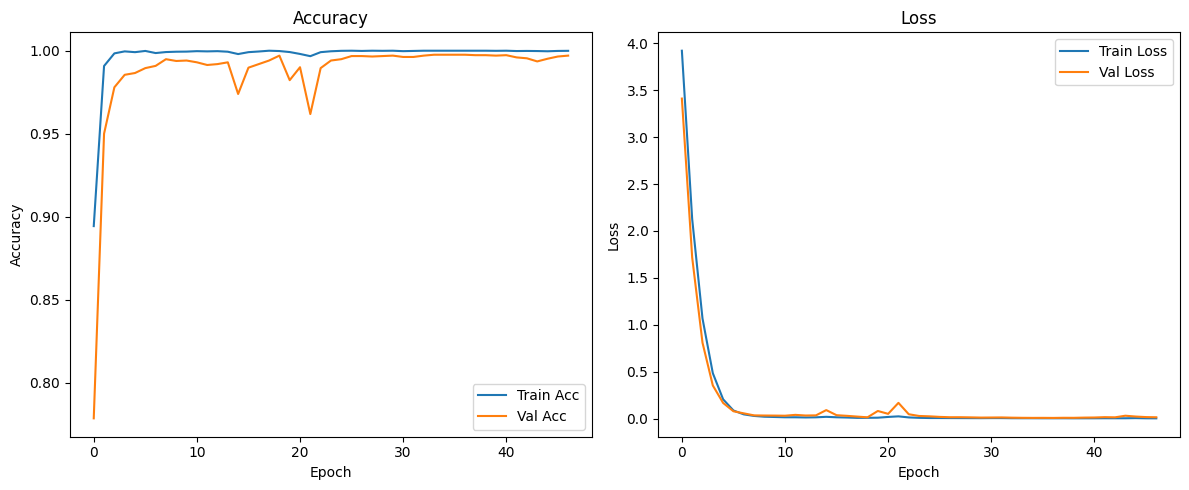

In [11]:
# === Set Random Seeds ===
def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    # Disable GPU non-deterministic operations
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    os.environ['PYTHONHASHSEED'] = str(seed)

# Set seed for reproducibility
set_seed(42)

# === Load Dataset ===
train_dir = output_split_path + 'train'

train_ds_raw = image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset='training',
    seed=42,
    image_size=(224, 224),
    batch_size=64,
    label_mode='categorical'
)

val_ds_raw = image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset='validation',
    seed=42,
    image_size=(224, 224),
    batch_size=32,
    label_mode='categorical'
)

class_names = train_ds_raw.class_names
num_classes = len(class_names)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds_raw.prefetch(AUTOTUNE)
val_ds = val_ds_raw.prefetch(AUTOTUNE)

# === Hitung Class Weights ===
labels = []
for _, y in train_ds_raw:
    labels.extend(np.argmax(y.numpy(), axis=1))

weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights = dict(enumerate(weights))

# === Augmentasi + Preprocessing ===
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomBrightness(0.2),
    layers.Resizing(224, 224)
])

# === MobileNetV2 Base ===
base_model = MobileNetV2(input_shape=(224, 224, 3),
                         include_top=False,
                         weights='imagenet')
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

# === Bangun Model ===
model = models.Sequential([
    layers.Rescaling(scale=1./127.5, offset=-1),
    base_model,
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.4),
    layers.Dense(num_classes, activation='softmax')
])

# === Compile ===
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.build((None, 224, 224, 3))
model.summary()

# === Callbacks ===
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-6, verbose=1)
checkpoint = ModelCheckpoint('best_model.weights.h5', monitor='val_loss',
                             save_best_only=True, save_weights_only=True, verbose=1)

# === Training ===
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr, checkpoint]
)

# === Simpan Model Final ===
model.save('final_model_mobilenetv2.h5')

# === Visualisasi ===
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Konversi Model menjadi Format SavedModel

In [35]:
# load model dari h5
model = tf.keras.models.load_model("final_model_mobilenetv2.h5")

# simpan dalam format savedmodel
model.export("saved_model")

# Folder model SavedModel
folder_path = '/content/saved_model'

# Path output zip (tanpa ekstensi .zip)
output_zip = '/content/saved_model'

# Zip folder
shutil.make_archive(output_zip, 'zip', folder_path)

Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_4')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  135777824586064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135778213508880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135778234993936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135778213504848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135777824586832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135778235000272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135778234997392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135776224870480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135777864509648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135777824582224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135776224872208: T

'/content/saved_model.zip'

# Konversi Model menjadi Format TFLite

In [36]:
# 1. Convert model ke TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Simpan model TFLite ke file
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

# 2. Simpan label ke file
labels = ['1000', '10000', '100000', '2000', '20000', '5000', '50000']
with open('labels.txt', 'w') as f:
    f.write('\n'.join(labels))

# 3. Buat folder dan pindahkan file
os.makedirs('tflite', exist_ok=True)

# Pastikan file ada sebelum dipindahkan
if os.path.exists('model.tflite') and os.path.exists('labels.txt'):
    os.rename('model.tflite', 'tflite/model.tflite')
    os.rename('labels.txt', 'tflite/labels.txt')
else:
    raise FileNotFoundError("Pastikan 'model.tflite' dan 'labels.txt' sudah ada.")

# 4. Kompres ke ZIP
zip_path = 'tflite.zip'
with zipfile.ZipFile(zip_path, 'w') as zipf:
    zipf.write('tflite/model.tflite', arcname='model.tflite')
    zipf.write('tflite/labels.txt', arcname='labels.txt')

print("Selesai: 'tflite.zip' siap digunakan.")


Saved artifact at '/tmp/tmp5pemx2_b'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_4')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  135777824586064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135778213508880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135778234993936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135778213504848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135777824586832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135778235000272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135778234997392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135776224870480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135777864509648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135777824582224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1357762248722

# Konversi Model menjadi Format tfjs

In [41]:
!tensorflowjs_converter --input_format=keras final_model_mobilenetv2.h5 tfjs_model
shutil.make_archive('tfjs_model', 'zip', 'tfjs_model')

2025-05-09 16:04:46.274502: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746806686.314206   35856 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746806686.326594   35856 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
failed to lookup keras version from the file,
    this is likely a weight only file


'/content/tfjs_model.zip'

# Evaluation

Found 2328 files belonging to 7 classes.
73/73 ━━━━━━━━━━━━━━━━━━━━ 24s 284ms/step


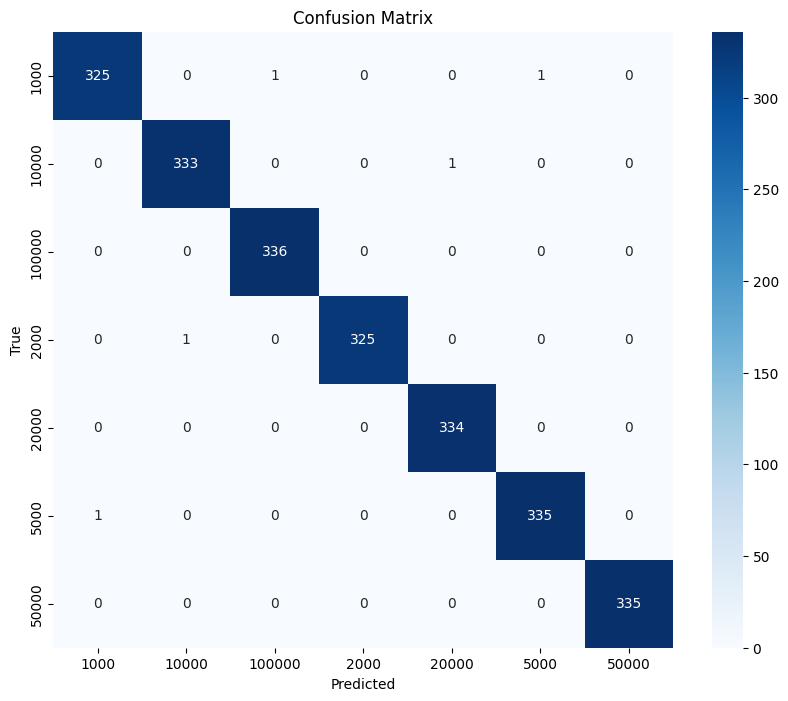

Classification Report:
              precision    recall  f1-score   support

        1000       1.00      0.99      1.00       327
       10000       1.00      1.00      1.00       334
      100000       1.00      1.00      1.00       336
        2000       1.00      1.00      1.00       326
       20000       1.00      1.00      1.00       334
        5000       1.00      1.00      1.00       336
       50000       1.00      1.00      1.00       335

    accuracy                           1.00      2328
   macro avg       1.00      1.00      1.00      2328
weighted avg       1.00      1.00      1.00      2328

73/73 ━━━━━━━━━━━━━━━━━━━━ 17s 230ms/step - accuracy: 0.9967 - loss: 0.0106
Test Loss: 0.0079, Test Accuracy: 0.9979


In [12]:
# ====================
# Load test dataset
# ====================
test_dir = output_split_path + 'test'

test_dataset = image_dataset_from_directory(
    test_dir,
    image_size=(224, 224),
    batch_size=32,
    label_mode='categorical',
    shuffle=False  # Penting agar urutan tetap
)

# ====================
# Prediksi
# ====================
y_true = np.concatenate([y.numpy() for _, y in test_dataset], axis=0)
y_true_labels = np.argmax(y_true, axis=1)

y_pred_probs = model.predict(test_dataset)
y_pred_labels = np.argmax(y_pred_probs, axis=1)

# ====================
# Confusion Matrix
# ====================
cm = confusion_matrix(y_true_labels, y_pred_labels)
class_names = test_dataset.class_names

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# ====================
# Classification Report
# ====================
print("Classification Report:")
print(classification_report(y_true_labels, y_pred_labels, target_names=class_names))

# ====================
# Model Evaluation (Optional)
# ====================
loss, accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")


# Inference

Upload image(s) for prediction:


Saving 10.jpg to 10.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Gambar: 10.jpg => Prediksi: 20000
Ini uang 20000


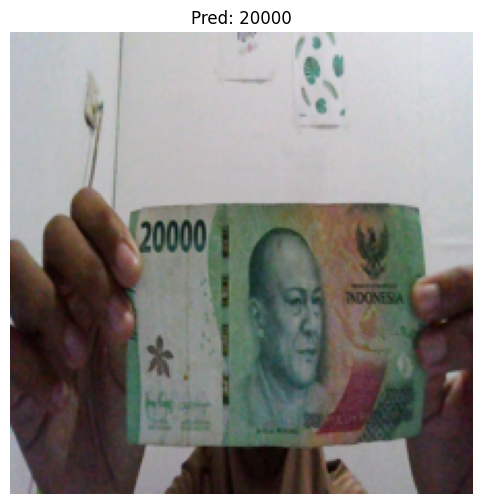

In [33]:
# ====================
# Install & Import
# ====================
from google.colab import files

# ====================
# Upload & Preprocess Image
# ====================
print("Upload image(s) for prediction:")
uploaded_images = files.upload()

image_list = []
image_names = []

for filename, filedata in uploaded_images.items():
    image = Image.open(io.BytesIO(filedata)).convert("RGB")
    image = image.resize((224, 224))  # <-- sesuaikan dengan input model
    image_array = img_to_array(image)
    image_list.append(image_array)
    image_names.append(filename)

X = np.array(image_list)
X = X   # Normalisasi jika model dilatih dengan input [0, 1]

# ====================
# Predict
# ====================
y_pred_probs = model.predict(X)
y_pred_labels = np.argmax(y_pred_probs, axis=1)

# ====================
# Output Prediction
# ====================
for name, label_idx in zip(image_names, y_pred_labels):
    print(f"Gambar: {name} => Prediksi: {class_names[label_idx]}")

# ====================
# Output Prediction with Voice (Modified)
# ====================
for name, label_idx in zip(image_names, y_pred_labels):
    predicted_class = class_names[label_idx]
    prediction_text = f"Ini uang {predicted_class}"  # Ganti dengan format yang diinginkan
    print(prediction_text)

    # Convert prediction to speech using gTTS
    tts = gTTS(text=prediction_text, lang='id')
    tts.save("prediction.mp3")

    # Play the generated speech
    audio = ipd.Audio("prediction.mp3")
    display(audio)  # Use display to show audio player in Colab

    # Add a small delay to ensure the audio is fully loaded
    import time
    time.sleep(2)

# ====================
# Show Images with Predictions
# ====================
plt.figure(figsize=(12, 6))
for i, (img_array, pred_idx) in enumerate(zip(image_list, y_pred_labels)):
    plt.subplot(1, len(image_list), i + 1)
    plt.imshow(img_array.astype("uint8"))
    plt.axis('off')
    plt.title(f'Pred: {class_names[pred_idx]}')
plt.show()


In [ ]:
# ====================
# Function to Capture Image from Webcam in Colab and Process it for Prediction
# ====================
def take_photo_and_predict():
    display(Javascript('''
        async function takePhoto() {
            const video = document.createElement('video');
            const stream = await navigator.mediaDevices.getUserMedia({ video: true });
            video.srcObject = stream;
            document.body.appendChild(video);
            video.play();

            // Set the width and height of video stream
            video.width = 640;  // Adjust the size for better webcam visibility
            video.height = 480;

            // Create a button to capture the image
            const button = document.createElement('button');
            button.innerHTML = "Capture";
            button.style.position = 'absolute';
            button.style.bottom = '10px';  // Position the button at the bottom
            button.style.left = '50%';
            button.style.transform = 'translateX(-50%)';
            button.style.padding = '10px 20px';
            button.style.fontSize = '16px';
            document.body.appendChild(button);

            button.onclick = async function() {
                // Capture the image from the video feed when button is clicked
                const canvas = document.createElement('canvas');
                document.body.appendChild(canvas);
                const ctx = canvas.getContext('2d');
                canvas.width = 224;
                canvas.height = 224;

                // Ensure the canvas has the correct resolution and draw the image
                ctx.drawImage(video, 0, 0, canvas.width, canvas.height);

                // Convert canvas to image
                const imageUrl = canvas.toDataURL('image/jpeg');
                const imageBlob = await (await fetch(imageUrl)).blob();
                const file = new File([imageBlob], 'captured_image.jpg', {type: 'image/jpeg'});

                // Send the image to Python for prediction
                const reader = new FileReader();
                reader.onload = function(event) {
                    const image_data = event.target.result;
                    google.colab.kernel.invokeFunction('process_captured_image', [image_data], {});
                }
                reader.readAsDataURL(file);
            }
        }
        takePhoto();
    '''))

# ====================
# Callback to Process Captured Image and Predict
# ====================
from google.colab import output

def process_captured_image(image_data):
    # Convert the base64 image URL to an image object
    import base64
    from io import BytesIO
    image_data = image_data.split(',')[1]
    image = Image.open(BytesIO(base64.b64decode(image_data))).convert("RGB")
    image = image.resize((224, 224))  # Resize to match the input size of the model
    image_array = img_to_array(image)  # Convert image to numpy array

    X = np.array([image_array])  # Prepare image for prediction

    # Predict with the model
    y_pred_probs = model.predict(X)
    y_pred_labels = np.argmax(y_pred_probs, axis=1)

    # ====================
    # Output Prediction
    # ====================
    print(f"Prediksi: {class_names[y_pred_labels[0]]}")

    # ====================
    # Output Prediction with Voice (Converted to Speech)
    # ====================
    prediction_text = f"Ini uang {class_names[y_pred_labels[0]]}"
    print(prediction_text)

    # Convert prediction to speech using gTTS (Google Text-to-Speech)
    tts = gTTS(text=prediction_text, lang='id')
    tts.save("prediction.mp3")

    # Play the generated speech
    audio = ipd.Audio("prediction.mp3")
    display(audio)  # Display audio player in Colab

    # Add a small delay to ensure the audio is fully loaded
    time.sleep(2)

    # ====================
    # Show the Image with Prediction
    # ====================
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.title(f'Pred: {class_names[y_pred_labels[0]]}')
    plt.show()

# Register the callback to handle the captured image
output.register_callback('process_captured_image', process_captured_image)

# ====================
# Trigger the Camera to Capture Image and Predict
# ====================
take_photo_and_predict()